[I 2025-04-28 18:37:35,193] A new study created in memory with name: no-name-e1db36b7-3516-4c0f-b1f7-8317cd47eebe
[I 2025-04-28 18:38:18,442] Trial 0 finished with value: 0.6078953998405447 and parameters: {'n_layers': 2, 'width': 324, 'dropout_rate': 0.39115675960191987}. Best is trial 0 with value: 0.6078953998405447.
[I 2025-04-28 18:39:06,385] Trial 1 finished with value: 1.2360902389419701 and parameters: {'n_layers': 6, 'width': 301, 'dropout_rate': 0.2052611042985844}. Best is trial 1 with value: 1.2360902389419701.
[I 2025-04-28 18:40:40,473] Trial 2 finished with value: 1.1984114407963382 and parameters: {'n_layers': 7, 'width': 481, 'dropout_rate': 0.3991833358036465}. Best is trial 1 with value: 1.2360902389419701.
[I 2025-04-28 18:41:56,251] Trial 3 finished with value: 1.1073403674357813 and parameters: {'n_layers': 7, 'width': 408, 'dropout_rate': 0.41840877538778287}. Best is trial 1 with value: 1.2360902389419701.
[I 2025-04-28 18:42:57,434] Trial 4 finished with value:

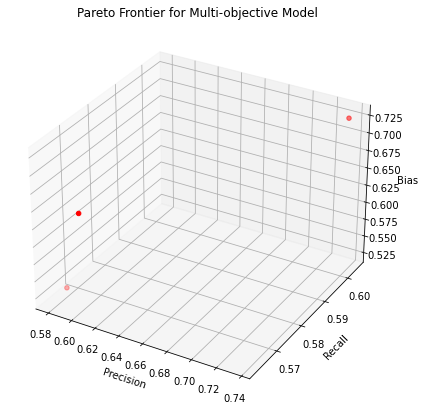

In [5]:
import os
import numpy as np
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv  # Added for CSV handling

# Basic settings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load datasets
train_dataset = ImageFolder(root="2/Training", transform=transform)
test_dataset = ImageFolder(root="2/Testing", transform=transform)

# Split training into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_set, val_set = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(train_dataset.classes)

# Model Definition (unchanged)
class CustomResNet(nn.Module):
    def __init__(self, n_layers, width, dropout_rate, num_classes):
        super(CustomResNet, self).__init__()
        self.features = self._make_layers(n_layers, width, dropout_rate)
        self.classifier = nn.Linear(width, num_classes)
    
    def _make_layers(self, n_layers, width, dropout_rate):
        layers = []
        in_channels = 3
        for i in range(n_layers):
            layers.append(nn.Conv2d(in_channels, width, kernel_size=3, stride=1, padding=1))
            layers.append(nn.BatchNorm2d(width))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            layers.append(nn.Dropout2d(p=dropout_rate))
            in_channels = width
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.features(x)
        x = nn.AdaptiveAvgPool2d((1, 1))(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Metrics (unchanged)
def calculate_metrics(y_true, y_pred, num_classes):
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    label_counts = cm.sum(axis=0)
    bias = np.std(label_counts) / (np.mean(label_counts) + 1e-6)
    return precision, recall, bias

# Objective function (unchanged)
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 7)
    width = trial.suggest_int('width', 50, 500)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)

    model = CustomResNet(n_layers, width, dropout_rate, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(3):
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(targets.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    precision, recall, bias = calculate_metrics(all_labels, all_preds, num_classes)
    return precision + recall - bias

# Optuna optimization (unchanged)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# New functionality: Store all points and Pareto frontier
def is_dominated(point, other):
    """Check if a point is dominated by another point"""
    return (other[3] >= point[3] and  # precision
            other[4] >= point[4] and  # recall
            other[5] <= point[5] and   # bias
            (other[3] > point[3] or other[4] > point[4] or other[5] < point[5]))

def get_pareto_frontier(results):
    """Identify Pareto-optimal points"""
    frontier = []
    for i, point in enumerate(results):
        dominated = False
        for j, other in enumerate(results):
            if i != j and is_dominated(point, other):
                dominated = True
                break
        if not dominated:
            frontier.append(point)
    return frontier

# Collect results with hyperparameters
results = []
best_trials = sorted(study.trials, key=lambda t: t.value, reverse=True)[:5]

for trial in best_trials:
    params = trial.params
    model = CustomResNet(**params, num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training (unchanged)
    for epoch in range(5):
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    # Evaluation (unchanged)
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(targets.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    precision, recall, bias = calculate_metrics(all_labels, all_preds, num_classes)
    
    # Store with hyperparameters and metrics
    results.append((
        params['n_layers'],
        params['width'],
        params['dropout_rate'],
        precision,
        recall,
        bias
    ))

# Save all points to CSV
with open('attempt_2_all_points.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['n_layers', 'width', 'dropout', 'precision', 'recall', 'bias'])
    writer.writerows(results)

# Get and save Pareto frontier
pareto_front = get_pareto_frontier(results)
with open('attempt_2_pareto_points.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['n_layers', 'width', 'dropout', 'precision', 'recall', 'bias'])
    writer.writerows(pareto_front)

# Visualization (unchanged)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
precisions = [r[3] for r in pareto_front]
recalls = [r[4] for r in pareto_front]
biases = [r[5] for r in pareto_front]
ax.scatter(precisions, recalls, biases, c='r', marker='o')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_zlabel('Bias')
plt.title('Pareto Frontier for Multi-objective Model')
plt.show()